In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline

from functools import partial

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

In [3]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### Import MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### set parameters

In [5]:
learning_rate = 0.01
l2_reg = 0.0001

training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28
n_hidden_1 = 256
n_hidden_2 = 128

# log directory for tensorboard
log_dir = '/tmp/tensorflow/training_one_autoencoder/logs/summaries'

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [6]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0005):
    with tf.variable_scope(name):
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init,
                                kernel_regularizer=l2_regularizer)
        
        
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        
        print(layer.name)
        
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

In [7]:
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu):
    
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])

        hidden = nn_layer(X, n_neurons, name="hidden", activation=activation)
        outputs = nn_layer(hidden, n_inputs, name="outputs", activation=None)
        
        print(hidden.name)

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
            
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)  # tf.add_n : 要素ごとの和

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()
            
        merged = tf.summary.merge_all()


    #if tf.gfile.Exists(log_dir):
    #    tf.gfile.DeleteRecursively(log_dir)
    if not tf.gfile.Exists(log_dir):
        tf.gfile.MakeDirs(log_dir)

    with tf.Session(graph=graph) as sess:
        init.run()
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        test_writer = tf.summary.FileWriter(log_dir + '/test')
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = np.random.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                summary, _ = sess.run([merged,training_op], feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            train_writer.add_summary(summary, epoch)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        train_writer.close()
        test_writer.close()
        
        return hidden_val, params["hidden/dense/kernel:0"], params["hidden/dense/bias:0"], params["outputs/dense/kernel:0"], params["outputs/dense/bias:0"]


In [ ]:
with tf.variable_scope('layer1'):
    hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, 
                                                      n_hidden_1, 
                                                      training_epochs, 
                                                      batch_size, 
                                                      learning_rate = 0.01, 
                                                      l2_reg = 0.0005,
                                                      activation=tf.nn.elu)

with tf.variable_scope('layer2'):    
    _, W2, b2, W3, b3  = train_autoencoder(hidden_output, 
                                           n_hidden_2, 
                                           training_epochs, 
                                           batch_size, 
                                           learning_rate = 0.01, 
                                           l2_reg = 0.0005,
                                           activation=tf.nn.elu)

hidden/dense/Elu:0
outputs/dense/BiasAdd:0
hidden/dense/Elu:0
0 Train MSE: 0.0175488
1 Train MSE: 0.0180942
2 Train MSE: 0.018676
3 Train MSE: 0.0193097
4 Train MSE: 0.019435
5 Train MSE: 0.0182807
6 Train MSE: 0.0189894
7 Train MSE: 0.0185454
8 Train MSE: 0.0191761
9 Train MSE: 0.0192114
hidden/dense/Elu:0
outputs/dense/BiasAdd:0
hidden/dense/Elu:0
0 Train MSE: 0.00382926
1 Train MSE: 0.00378563
2 Train MSE: 0.00375578
3 Train MSE: 0.00400931
62%

In [11]:
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(v)

/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


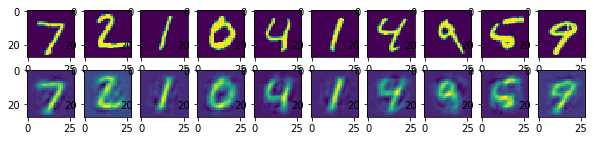

In [10]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

# Applying encode and decode over test set
with tf.Session() as sess:
    encode_decode = sess.run(outputs,feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()